# Data Analysis Assignment 1

James Matthew Garcia<br>
Rykelle Wei Ruellan

In [8]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.optimize import linprog
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [9]:
n_samples = 100

data = pd.DataFrame({
    'patient_id': np.arange(n_samples),
    'pain_score': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'urgency_score': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'nocturnal_freq': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'treated': np.random.choice([0, 1], n_samples, p=[0.5, 0.5]),  # 0 = Control, 1 = Treated
    'outcome_3_months_pain': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'outcome_6_months_pain': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'outcome_3_months_urgency': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'outcome_6_months_urgency': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'outcome_3_months_nocturnal': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'outcome_6_months_nocturnal': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'followup_pain': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'followup_urgency': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples),
    'followup_nocturnal': np.random.randint(1, 10, n_samples) + np.random.normal(0, 1, n_samples)
})

# Calculate changes at 3 months and 6 months
data['change_3_months_pain'] = data['outcome_3_months_pain'] - data['pain_score']
data['change_6_months_pain'] = data['outcome_6_months_pain'] - data['pain_score']
data['change_3_months_urgency'] = data['outcome_3_months_urgency'] - data['urgency_score']
data['change_6_months_urgency'] = data['outcome_6_months_urgency'] - data['urgency_score']
data['change_3_months_nocturnal'] = data['outcome_3_months_nocturnal'] - data['nocturnal_freq']
data['change_6_months_nocturnal'] = data['outcome_6_months_nocturnal'] - data['nocturnal_freq']


In [10]:
def compute_mahalanobis_distance(df, cov_matrix_inv):
    """Computes Mahalanobis distance for matching."""
    treated = df[df['treated'] == 1]
    control = df[df['treated'] == 0]

    matches = []
    distances = []
    for idx, row in treated.iterrows():
        if control.empty:
            print(f"No control matches left for treated patient {row['patient_id']}")
            continue

        dists = control.apply(lambda x: mahalanobis(
            row[['pain_score', 'urgency_score', 'nocturnal_freq']],
            x[['pain_score', 'urgency_score', 'nocturnal_freq']],
            cov_matrix_inv), axis=1)

        if dists.empty:
            print(f"No control matches found for treated patient {row['patient_id']}")
            continue

        best_match_idx = dists.idxmin()
        best_match = control.loc[best_match_idx]
        matches.append((row['patient_id'], best_match['patient_id'], dists[best_match_idx]))
        control = control.drop(best_match.name)

    return matches

# Compute inverse covariance matrix
cov_matrix = np.cov(data[['pain_score', 'urgency_score', 'nocturnal_freq']].T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

matched_pairs = compute_mahalanobis_distance(data, inv_cov_matrix)

# Create DataFrame
results_df = pd.DataFrame(matched_pairs, columns=['Treated ID', 'Control ID', 'Mahalanobis Distance'])

# Sort the DataFrame by Mahalanobis Distance
results_df = results_df.sort_values(by='Mahalanobis Distance').reset_index(drop=True)

# Print results using tabulate
print("🔹 Initial Matching Results - Sorted by Mahalanobis Distance (Pairs: {})".format(len(results_df)))
print("="*50)
print(tabulate(results_df, headers="keys", tablefmt="pretty", showindex=False))

# Print summary statistics
print("\nSummary Statistics:")
print(tabulate([
    ["Minimum Distance", f"{results_df['Mahalanobis Distance'].min():.2f}"],
    ["Maximum Distance", f"{results_df['Mahalanobis Distance'].max():.2f}"],
    ["Mean Distance", f"{results_df['Mahalanobis Distance'].mean():.2f}"],
    ["Median Distance", f"{results_df['Mahalanobis Distance'].median():.2f}"]
], headers=["Metric", "Value"], tablefmt="pretty"))


No control matches left for treated patient 94.0
No control matches left for treated patient 96.0
No control matches left for treated patient 98.0
No control matches left for treated patient 99.0
🔹 Initial Matching Results - Sorted by Mahalanobis Distance (Pairs: 48)
+------------+------------+----------------------+
| Treated ID | Control ID | Mahalanobis Distance |
+------------+------------+----------------------+
|    41.0    |    61.0    | 0.29989993482003596  |
|    79.0    |    18.0    | 0.38110938692176544  |
|    59.0    |    14.0    | 0.38708514848690545  |
|    70.0    |    50.0    | 0.41622754552214225  |
|    21.0    |    33.0    |  0.4445937534395878  |
|    8.0     |    66.0    |  0.4785007553650382  |
|    12.0    |    6.0     |  0.4806656188344613  |
|    44.0    |    29.0    |  0.5211923461500438  |
|    53.0    |    60.0    |  0.5368626173429654  |
|    26.0    |    28.0    |  0.5465068530112842  |
|    7.0     |    2.0     |  0.5489277793442302  |
|    15.0    |    

In [11]:
def analyze_matched_data(data, matched_pairs):
    """Computes Wilcoxon signed-rank tests on matched pairs."""
    treated_vals = data.loc[[x[0] for x in matched_pairs], [
        'pain_score', 'urgency_score', 'nocturnal_freq',
        'outcome_3_months_pain', 'outcome_6_months_pain',
        'outcome_3_months_urgency', 'outcome_6_months_urgency',
        'outcome_3_months_nocturnal', 'outcome_6_months_nocturnal',
        'followup_pain', 'followup_urgency', 'followup_nocturnal',
        'change_3_months_pain', 'change_6_months_pain',
        'change_3_months_urgency', 'change_6_months_urgency',
        'change_3_months_nocturnal', 'change_6_months_nocturnal'
    ]]
    control_vals = data.loc[[x[1] for x in matched_pairs], [
        'pain_score', 'urgency_score', 'nocturnal_freq',
        'outcome_3_months_pain', 'outcome_6_months_pain',
        'outcome_3_months_urgency', 'outcome_6_months_urgency',
        'outcome_3_months_nocturnal', 'outcome_6_months_nocturnal',
        'followup_pain', 'followup_urgency', 'followup_nocturnal',
        'change_3_months_pain', 'change_6_months_pain',
        'change_3_months_urgency', 'change_6_months_urgency',
        'change_3_months_nocturnal', 'change_6_months_nocturnal'
    ]]

    wilcoxon_results = {
        col: wilcoxon(treated_vals[col], control_vals[col])
        for col in treated_vals.columns
    }

    return wilcoxon_results

treated_indices = data[data['treated'] == 1].index.tolist()
control_indices = data[data['treated'] == 0].index.tolist()

# Shuffle for randomness
np.random.shuffle(control_indices)

# Pair treated with control (assuming equal numbers)
balanced_pairs = list(zip(treated_indices[:len(control_indices)], control_indices[:len(treated_indices)]))

wilcoxon_results = analyze_matched_data(data, balanced_pairs)

# Format results into a DataFrame
wilcoxon_df = pd.DataFrame([
    [outcome, result.statistic, result.pvalue]
    for outcome, result in wilcoxon_results.items()
], columns=["Outcome", "Test Statistic", "p-value"])

# Print Wilcoxon test results using tabulate
print("\nWilcoxon Signed-Rank Test Results:")
print("="*50)
print(tabulate(wilcoxon_df, headers="keys", tablefmt="pretty", showindex=False))



Wilcoxon Signed-Rank Test Results:
+----------------------------+----------------+---------------------+
|          Outcome           | Test Statistic |       p-value       |
+----------------------------+----------------+---------------------+
|         pain_score         |     587.0      | 0.9959463741864667  |
|       urgency_score        |     552.0      | 0.7182044463024582  |
|       nocturnal_freq       |     563.0      | 0.8033673532143482  |
|   outcome_3_months_pain    |     521.0      | 0.49862110993961295 |
|   outcome_6_months_pain    |     547.0      | 0.6805338329974404  |
|  outcome_3_months_urgency  |     516.0      | 0.4667978304528688  |
|  outcome_6_months_urgency  |     577.0      | 0.9150317491067099  |
| outcome_3_months_nocturnal |     519.0      | 0.4857576752241073  |
| outcome_6_months_nocturnal |     390.0      | 0.04205968011246597 |
|       followup_pain        |     562.0      | 0.7955129094812108  |
|      followup_urgency      |     411.0      | 0.0700

In [12]:
def balance_matching(data, matched_pairs, inv_cov_matrix):
    """Uses integer programming to balance matching across quantiles."""
    
    # Ensure valid matched_pairs
    matched_pairs = [pair for pair in matched_pairs if isinstance(pair, tuple) and len(pair) == 2]

    # Define balance constraints (pain, urgency, frequency at 1/3 and 2/3 quantiles)
    balance_constraints = {
        'pain_score': np.percentile(data['pain_score'], [33, 66]),
        'urgency_score': np.percentile(data['urgency_score'], [33, 66]),
        'nocturnal_freq': np.percentile(data['nocturnal_freq'], [33, 66])
    }

    # Integer programming setup
    num_pairs = len(matched_pairs)
    cost_matrix = np.zeros(num_pairs)  # Store Mahalanobis distances

    for i, (t_id, c_id) in enumerate(matched_pairs):
        try:
            t_row = data.loc[data['patient_id'] == t_id].iloc[0]
            c_row = data.loc[data['patient_id'] == c_id].iloc[0]

            # Compute cost based on Mahalanobis distance
            cost_matrix[i] = mahalanobis(
                t_row[['pain_score', 'urgency_score', 'nocturnal_freq']],
                c_row[['pain_score', 'urgency_score', 'nocturnal_freq']],
                inv_cov_matrix
            )
        except IndexError:
            print(f"Skipping invalid pair: ({t_id}, {c_id})")
            continue

    # Define linear programming constraints
    A_eq = np.ones((1, num_pairs))  # Ensuring all pairs are considered
    b_eq = np.array([num_pairs])    # Number of pairs to match

    res = linprog(cost_matrix, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1), method='highs')

    if res.success:
        balanced_matches = [matched_pairs[i] for i in range(num_pairs) if res.x[i] > 0.5]
        print(f"\n✅ Balanced matching successful! Pairs found: {len(balanced_matches)}")
        return balanced_matches
    else:
        print("\n❌ Balanced matching failed.")
        return []

# Generate treated and control indices
treated_indices = data[data['treated'] == 1].index.tolist()
control_indices = data[data['treated'] == 0].index.tolist()

# Shuffle for randomness
np.random.shuffle(control_indices)

# Ensure we have valid pairs
num_pairs = min(len(treated_indices), len(control_indices))
matched_pairs = list(zip(treated_indices[:num_pairs], control_indices[:num_pairs]))

# Perform balance matching
balanced_pairs = balance_matching(data, matched_pairs, inv_cov_matrix)

# Compute distances for balanced pairs
balanced_distances = []
for t_id, c_id in balanced_pairs:
    t_row = data.loc[data['patient_id'] == t_id].iloc[0]
    c_row = data.loc[data['patient_id'] == c_id].iloc[0]
    distance = mahalanobis(
        t_row[['pain_score', 'urgency_score', 'nocturnal_freq']],
        c_row[['pain_score', 'urgency_score', 'nocturnal_freq']],
        inv_cov_matrix
    )
    balanced_distances.append(distance)

# Create a DataFrame for the balanced pairs and distances
balanced_results_df = pd.DataFrame(balanced_pairs, columns=['Treated ID', 'Control ID'])
balanced_results_df['Mahalanobis Distance'] = balanced_distances

# Sort the DataFrame by Mahalanobis Distance
balanced_results_df = balanced_results_df.sort_values(by='Mahalanobis Distance').reset_index(drop=True)

# Display the results
print("\n🔹 Final Balanced Matching Results - Sorted by Mahalanobis Distance")
print("="*60)
print(f"{'Treated ID':<15}{'Control ID':<15}{'Mahalanobis Distance':<20}")
print("="*60)
for index, row in balanced_results_df.iterrows():
    print(f"{row['Treated ID']:<15}{row['Control ID']:<15}{row['Mahalanobis Distance']:<20.2f}")

# Print summary statistics
print("\n📊 Summary Statistics")
print("-"*30)
print(f"Minimum Distance: {balanced_results_df['Mahalanobis Distance'].min():.2f}")
print(f"Maximum Distance: {balanced_results_df['Mahalanobis Distance'].max():.2f}")
print(f"Mean Distance: {balanced_results_df['Mahalanobis Distance'].mean():.2f}")
print(f"Median Distance: {balanced_results_df['Mahalanobis Distance'].median():.2f}")


✅ Balanced matching successful! Pairs found: 48

🔹 Final Balanced Matching Results - Sorted by Mahalanobis Distance
Treated ID     Control ID     Mahalanobis Distance
9.0            42.0           0.59                
19.0           51.0           0.68                
25.0           28.0           0.82                
86.0           69.0           0.82                
58.0           32.0           1.09                
73.0           50.0           1.12                
52.0           90.0           1.43                
53.0           47.0           1.51                
59.0           74.0           1.51                
15.0           20.0           1.71                
27.0           30.0           1.77                
87.0           34.0           1.77                
89.0           5.0            1.84                
1.0            24.0           1.85                
8.0            10.0           2.00                
91.0           17.0           2.11                
80.0           8


Pain Score


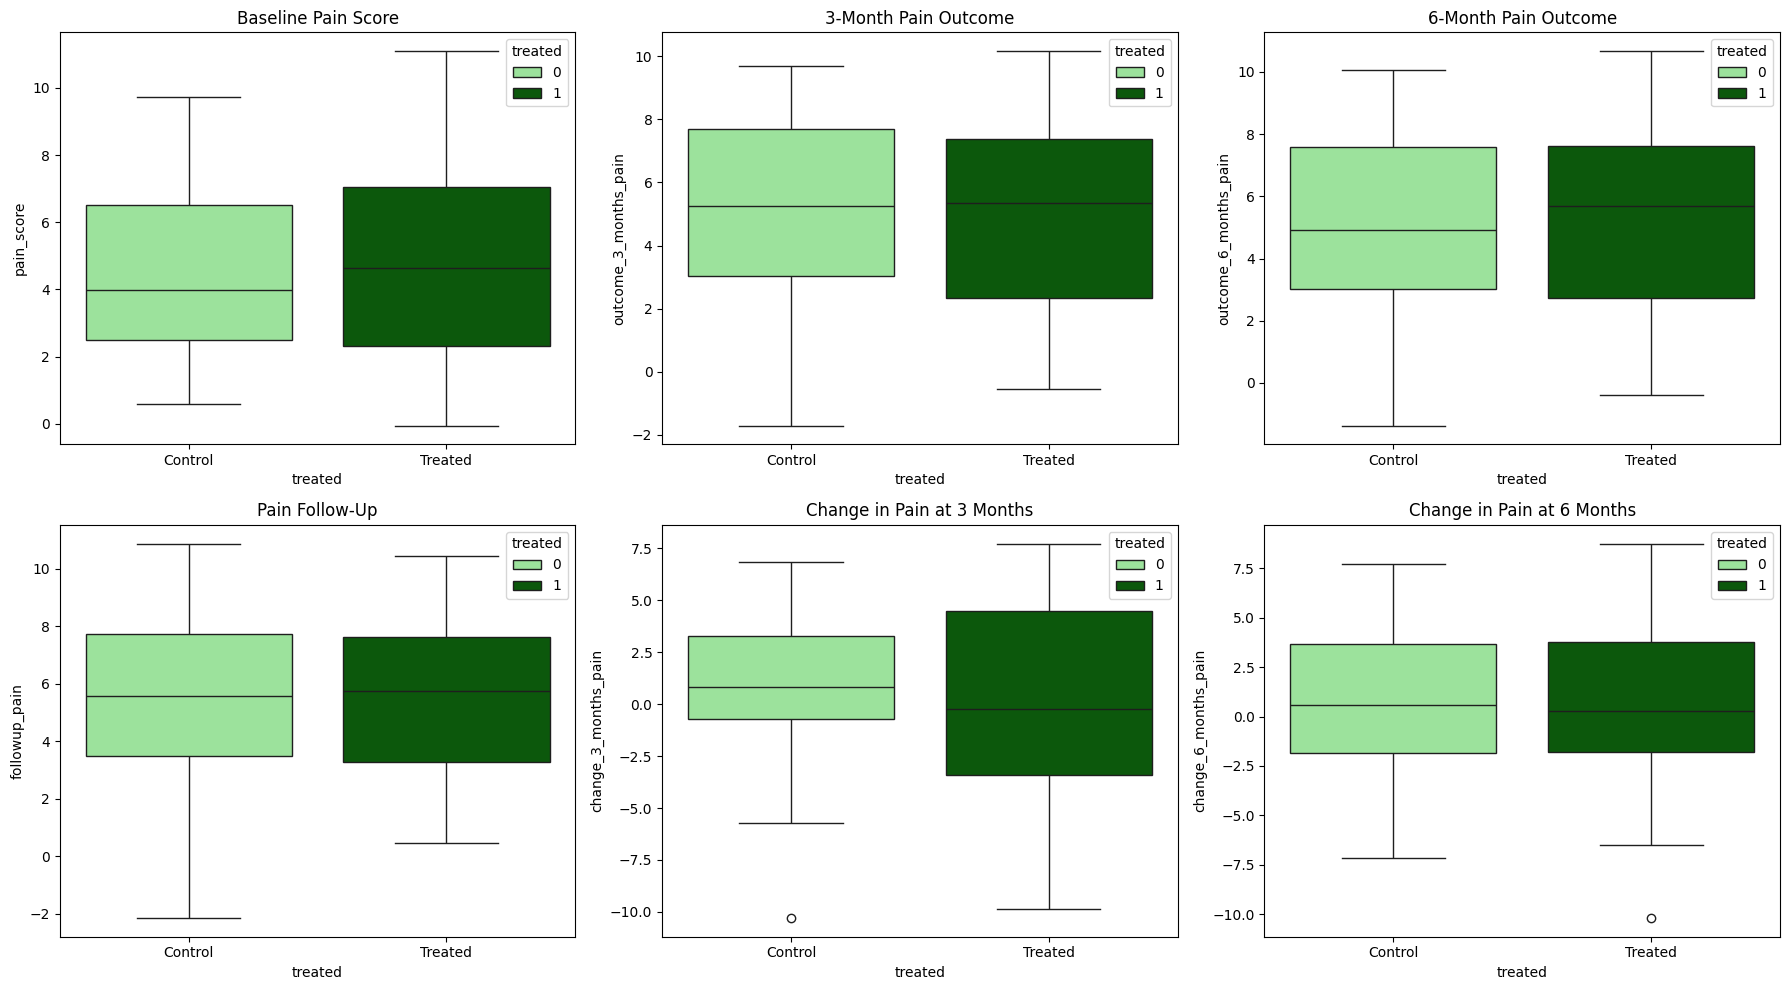


Urgency Score


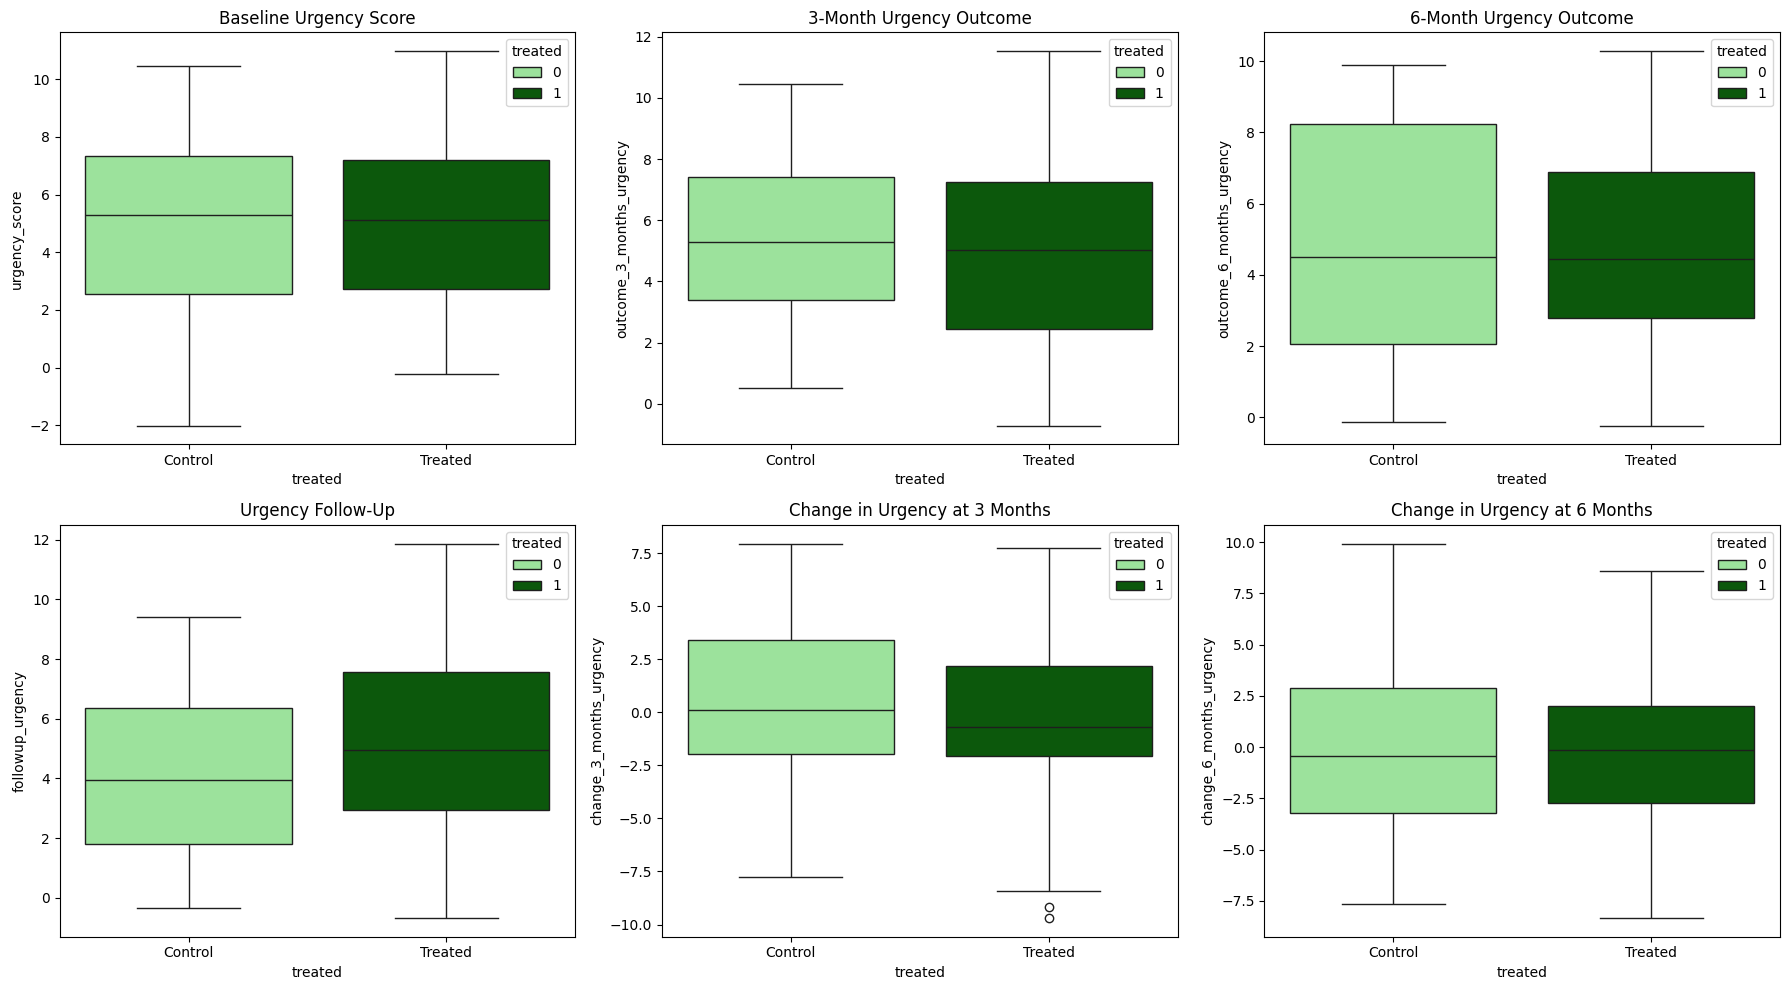


Nocturnal Frequency


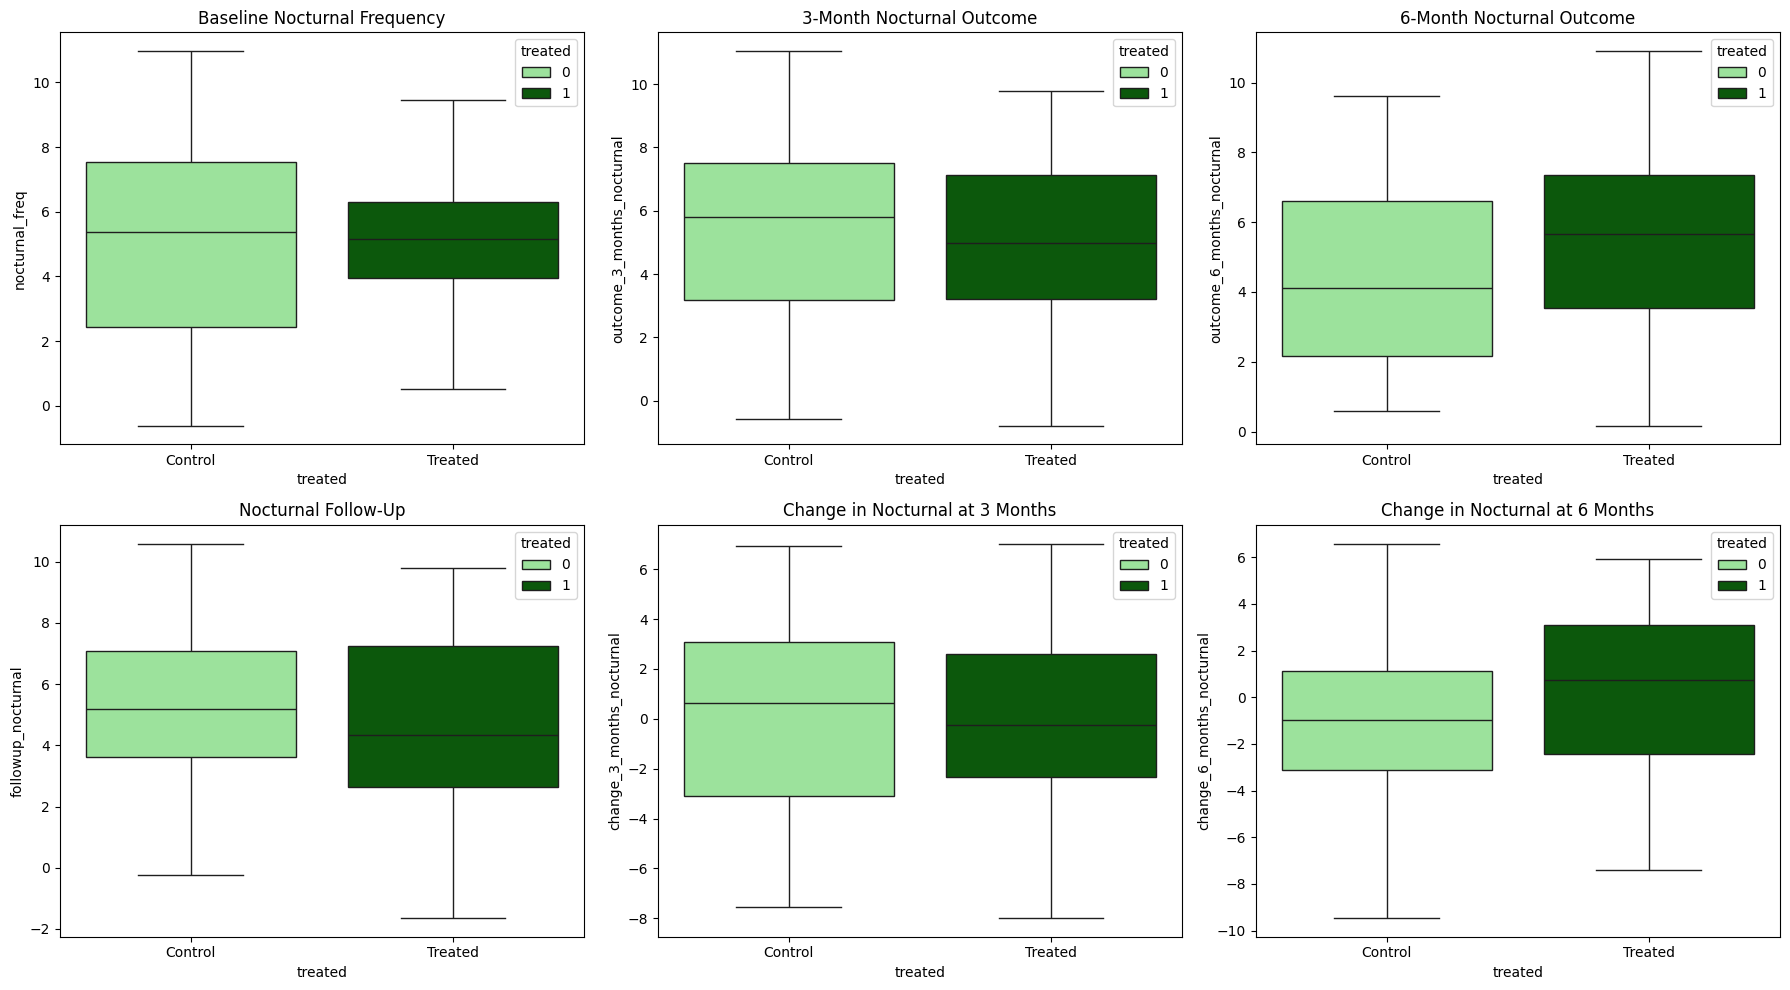

In [14]:
def plot_results(data):
    """Generates boxplots comparing treated vs control groups."""
    sections = {
        'Pain Score': [
            ('pain_score', 'Baseline Pain Score'),
            ('outcome_3_months_pain', '3-Month Pain Outcome'),
            ('outcome_6_months_pain', '6-Month Pain Outcome'),
            ('followup_pain', 'Pain Follow-Up'),
            ('change_3_months_pain', 'Change in Pain at 3 Months'),
            ('change_6_months_pain', 'Change in Pain at 6 Months')
        ],
        'Urgency Score': [
            ('urgency_score', 'Baseline Urgency Score'),
            ('outcome_3_months_urgency', '3-Month Urgency Outcome'),
            ('outcome_6_months_urgency', '6-Month Urgency Outcome'),
            ('followup_urgency', 'Urgency Follow-Up'),
            ('change_3_months_urgency', 'Change in Urgency at 3 Months'),
            ('change_6_months_urgency', 'Change in Urgency at 6 Months')
        ],
        'Nocturnal Frequency': [
            ('nocturnal_freq', 'Baseline Nocturnal Frequency'),
            ('outcome_3_months_nocturnal', '3-Month Nocturnal Outcome'),
            ('outcome_6_months_nocturnal', '6-Month Nocturnal Outcome'),
            ('followup_nocturnal', 'Nocturnal Follow-Up'),
            ('change_3_months_nocturnal', 'Change in Nocturnal at 3 Months'),
            ('change_6_months_nocturnal', 'Change in Nocturnal at 6 Months')
        ]
    }

    for section, outcomes in sections.items():
        print(f"\n{section}")
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        for i, (outcome, title) in enumerate(outcomes):
            sns.boxplot(x='treated', y=outcome, hue='treated', data=data, ax=axes[i], palette=['lightgreen', 'darkgreen'])
            axes[i].set_title(title)
            axes[i].set_xticks([0, 1])
            axes[i].set_xticklabels(["Control", "Treated"])
        plt.tight_layout()
        plt.show()

plot_results(data)